## Информация о текущей версии

In [1]:
from codeplag.consts import UTIL_VERSION, UTIL_NAME

print(f"{UTIL_NAME}-{UTIL_VERSION}")

codeplag-0.6.1


# Быстрый поиск схожих работ без подробностей

In [2]:
from codeplag.algorithms.tokenbased import value_jakkar_coef
from codeplag.getfeatures import get_files_path_from_directory
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast

In [3]:
import re
from pathlib import Path
from pprint import pprint

py_files = get_files_path_from_directory(
    Path(f"/usr/src/{UTIL_NAME}/src/{UTIL_NAME}/algorithms"),
    extensions=(re.compile(r".py$"),)
)
py_files = list(filter(lambda file: file.name != "__init__.py", py_files))
print("Количество файлов:", len(py_files))
pprint(py_files)

Количество файлов: 4
[PosixPath('/usr/src/codeplag/src/codeplag/algorithms/tokenbased.py'),
 PosixPath('/usr/src/codeplag/src/codeplag/algorithms/compare.py'),
 PosixPath('/usr/src/codeplag/src/codeplag/algorithms/stringbased.py'),
 PosixPath('/usr/src/codeplag/src/codeplag/algorithms/featurebased.py')]


In [4]:
import pandas as pd
import numpy as np
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast


mapped_files = list(map(lambda x: str(x).split('/')[-1], py_files))
count_files = len(py_files)
df = pd.DataFrame(
    index=mapped_files,
    columns=mapped_files,
    data=np.zeros(
        (count_files, count_files)
    )
)
for i, file1 in enumerate(py_files):
    tree1 = get_ast_from_filename(file1)
    features1 = get_features_from_ast(tree1, file1)
    for j, file2 in enumerate(py_files):
        if i == j:
            df.iloc[i, j] = 1.0
            break

        tree2 = get_ast_from_filename(file2)
        features2 = get_features_from_ast(tree2, file2)
        result = value_jakkar_coef(features1.tokens, features2.tokens) 
        df.iloc[i, j] = result
        df.iloc[j, i] = result
        j += 1
    i += 1
print(df)

                 tokenbased.py  compare.py  stringbased.py  featurebased.py
tokenbased.py         1.000000    0.377551        0.437037         0.475862
compare.py            0.377551    1.000000        0.292683         0.325926
stringbased.py        0.437037    0.292683        1.000000         0.442424
featurebased.py       0.475862    0.325926        0.442424         1.000000


**Чем ближе к нулю значение метрики, тем меньше соответсвие двух исходных кодов программ, чем ближе к единице, тем выше схожесть.**

Можно обозначить пороговое значение, при котором будет срабатывать предупреждение, что работы похожи по содрежанию, к примеру и запускать более показательные алгоритмы, которые смогут показать схожие части двух программ.

<AxesSubplot: >

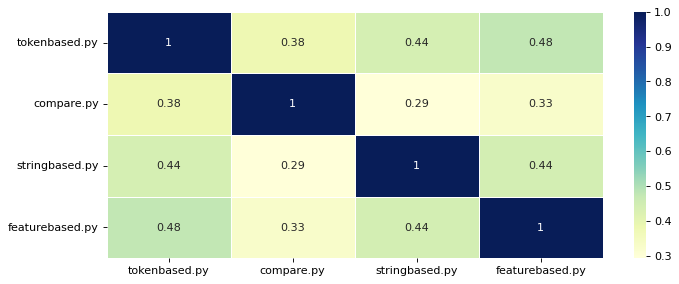

In [5]:
from matplotlib.pyplot import figure
import seaborn as sns

figure(figsize=(10, 4), dpi=80)
sns.heatmap(df, annot=True, linewidths=.6, cmap="YlGnBu")

# Быстрый поиск схожих работ без подробностей на основе составной метрики

Данная метрика состоит из коэффициента Жаккара и трёх метрик счёткиков. Каждому полученному значению применённых алгоритмов ставится свой вес.

In [6]:
from codeplag.algorithms.compare import fast_compare

import pandas as pd
import numpy as np
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast

weights = np.array([1, 0.4, 0.4, 0.4], dtype=np.float32)
df = pd.DataFrame(
    index=mapped_files,
    columns=mapped_files,
    data=np.zeros(
        (count_files, count_files)
    )
)
for i, file1 in enumerate(py_files):
    tree1 = get_ast_from_filename(file1)
    features1 = get_features_from_ast(tree1, file1)
    for j, file2 in enumerate(py_files):
        if i == j:
            df.iloc[i, j] = 1.0
            break

        tree2 = get_ast_from_filename(file2)
        features2 = get_features_from_ast(tree2, file2)
        result = fast_compare(features1, features2, weights=weights)
        df.iloc[i, j] = result.weighted_average
        df.iloc[j, i] = result.weighted_average
        j += 1
    i += 1
print(df)

                 tokenbased.py  compare.py  stringbased.py  featurebased.py
tokenbased.py         1.000000    0.285752        0.475421         0.435390
compare.py            0.285752    1.000000        0.258014         0.207916
stringbased.py        0.475421    0.258014        1.000000         0.420607
featurebased.py       0.435390    0.207916        0.420607         1.000000


<AxesSubplot: >

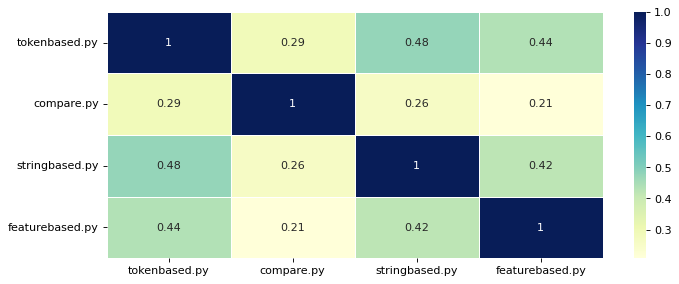

In [7]:
from matplotlib.pyplot import figure
import seaborn as sns

figure(figsize=(10, 4), dpi=80)
sns.heatmap(df, annot=True, linewidths=.6, cmap="YlGnBu")

# Поиск схожих частей верхних уровней, построенный на собственном алгоритме (работает долго, точность поиска не гаранитруется)

In [8]:
from codeplag.algorithms.featurebased import struct_compare

In [9]:
filename1 = Path("/usr/src/codeplag/src/codeplag/algorithms/stringbased.py")
filename2 = Path("/usr/src/codeplag/src/codeplag/algorithms/tokenbased.py")
tree1 = get_ast_from_filename(filename1)
tree2 = get_ast_from_filename(filename2)
features1 = get_features_from_ast(tree1, filename1)
features2 = get_features_from_ast(tree2, filename2)

<AxesSubplot: >

<Figure size 400x160 with 0 Axes>

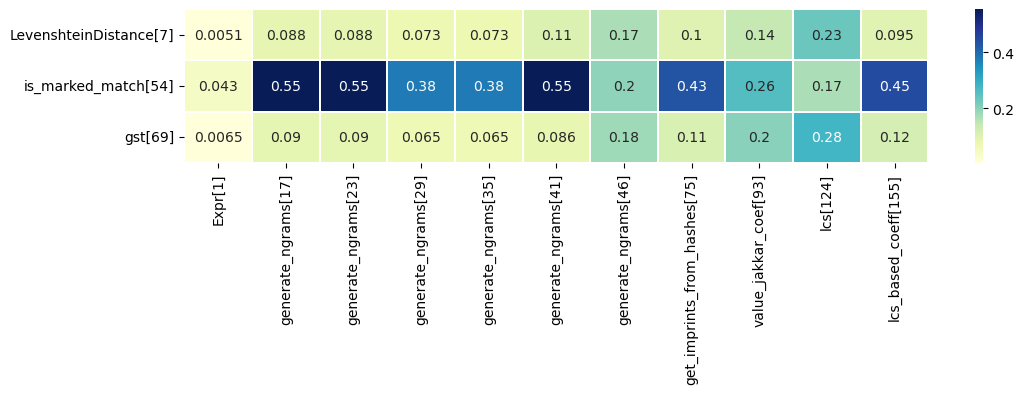

In [10]:
import matplotlib.pyplot as plt

compliance_matrix = np.zeros((len(features1.head_nodes),
                              len(features2.head_nodes), 2),
                             dtype=np.int64)
struct_res = struct_compare(features1.structure, features2.structure, compliance_matrix)
data = np.zeros((compliance_matrix.shape[0],
                 compliance_matrix.shape[1]),
                dtype=np.float32)
for row in range(compliance_matrix.shape[0]):
    for col in range(compliance_matrix.shape[1]):
        data[row][col] = (compliance_matrix[row][col][0] / compliance_matrix[row][col][1])

df = pd.DataFrame(data=data, index=features1.head_nodes, columns=features2.head_nodes)
figure(figsize=(5, 2), dpi=80)
plt.figure(figsize=(12, 2))
sns.heatmap(df, annot=True, linewidths=0.3, cmap="YlGnBu")

# Вывод схожих фрагментов двух программ с помощью  Greedy String Tiling алгоритма

In [11]:
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast

In [12]:
from codeplag.algorithms.stringbased import gst

answer = gst(features1.tokens, features2.tokens, 7)

In [13]:
from codeplag.display import print_suspect_parts

with open(filename1, 'r') as f:
    text1 = f.read()

with open(filename2, 'r') as f:
    text2 = f.read()

print_suspect_parts(text1, answer[0], features1.tokens_pos)


        self.s1_length = len(sequence1)
        self.s2_length = len(sequence2)
        """Calculates the Levenshtein distance.
        for i in range(self.s1_length + 1):
                symbol1 = self.sequence1[row - 1]
                symbol2 = self.sequence2[column - 1]
                        self.distance_matrix[row - 1][column] + 1,
                        self.distance_matrix[row][column - 1] + 1,
                        self.distance_matrix[row - 1][column - 1] + self.m(symbol1, symbol2),
                self.distance_matrix[row][column] = minimum
        self.distance = self.distance_matrix[self.s1_length][self.s2_length]
    def get_similarity_value(self: Self) -> float:
        return 1.0 - self.distance / max(self.s1_length, self.s2_length)
def is_marked_match(marked_string_list: list[int], begin: int, length: int) -> bool:
    """The function returns true if the match consists in the marked list, else false.
    sequence1: Sequence, sequence2: Sequence, min_match_len: in

In [14]:
print_suspect_parts(text2, answer[1], features2.tokens_pos)


@overload
) -> list[int]: ...
def generate_ngrams(
    tokens: Sequence[int], n: int, hashit: Literal[True], unique: Literal[True]
    tokens: Sequence[int], n: int = 3, hashit: bool = False, unique: bool = False
) -> set[int] | list[int] | set[tuple[int, ...]] | list[tuple[int, ...]]: ...
    count_hashes = len(hashes)
    k = math.floor(math.log(count_hashes, 2))
    intersection = len(ngrams_first.intersection(ngrams_second))
    union = len(ngrams_first | ngrams_second)
    L = [[0] * (n + 1) for i in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            elif X[i - 1] == Y[j - 1]:
                L[i][j] = L[i - 1][j - 1] + 1

**NB.** Строки документации (""" """, не путать с #) в Python считаются константным значением поэтому GST определяет, что функции, отличающиеся только наличием документации отличаются и совпадают только в месте самого исполнения кода. Нужно учитывать, что обычно такие строки не будут писаться просто так, либо исключать их из программы.

**NB.** Для выделения схожим фрагментов стоит воспользоваться функций print_code_and_highlight_suspect из codeplag.display.utils. Подстветка будет работать в консоли.

# Взаимодействие с удалёнными репозиториями

In [15]:
from webparsers.github_parser import GitHubParser
from decouple import Config, RepositoryEnv

env_config = Config(RepositoryEnv('../../.env'))
gh = GitHubParser(access_token=env_config.get('ACCESS_TOKEN'))

**Ключ - название репозитория, значение - ссылка на репозиторий**

In [16]:
gh.get_list_of_repos('OSLL', reg_exp=re.compile(r"[abc]df\w*21"))

[Repository(name='adfmp1h21-birds', html_url='https://github.com/OSLL/adfmp1h21-birds'),
 Repository(name='adfmp1h21-mushrooms', html_url='https://github.com/OSLL/adfmp1h21-mushrooms'),
 Repository(name='adfmp1h21-verbal-counting', html_url='https://github.com/OSLL/adfmp1h21-verbal-counting'),
 Repository(name='adfmp1h21-crocodile', html_url='https://github.com/OSLL/adfmp1h21-crocodile'),
 Repository(name='adfmp1h21-alias', html_url='https://github.com/OSLL/adfmp1h21-alias'),
 Repository(name='adfmp1h21-iq', html_url='https://github.com/OSLL/adfmp1h21-iq')]

In [17]:
gh.get_name_default_branch('OSLL', 'code-plagiarism')

'main'

**Ключ - название ветки, значение - sha commit'а**

In [18]:
gh.get_list_repo_branches('OSLL', 'code-plagiarism')

[BranchInfo(name='github_url_arg', last_commit=Commit(sha='875eafb3fb6de757b22a121dcd56ab0c2ffda676', date='2025-12-05T18:36:16Z')),
 BranchInfo(name='main', last_commit=Commit(sha='6c84dcbfa0f637bf8b30a9ab37062fe36737985a', date='2025-11-30T09:46:33Z'))]

In [19]:
print(
    next(gh.get_files_generator_from_url('https://github.com/OSLL/code-plagiarism/blob/main/LICENSE')).code
)

MIT License

Copyright (c) 2021-2025 Codeplag Development Team

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
O

In [20]:
files1 = list(
    gh.get_files_generator_from_repo_url(
        "https://github.com/OSLL/code-plagiarism",
        path_regexp=re.compile(r".py$")
    )
)

In [21]:
print(files1[2][0])

from codeplag.types import ExitCode


def main() -> ExitCode:
    import argcomplete
    import pandas as pd

    from codeplag.codeplagcli import CodeplagCLI
    from codeplag.config import read_settings_conf
    from codeplag.consts import LOG_PATH
    from codeplag.logger import codeplag_logger as logger
    from codeplag.logger import set_handlers
    from codeplag.translate import get_translations
    from codeplag.utils import CodeplagEngine

    pd.set_option("display.float_format", "{:,.2%}".format)
    pd.set_option("display.max_colwidth", None)

    translations = get_translations()
    translations.install()

    cli = CodeplagCLI()
    argcomplete.autocomplete(cli)
    parsed_args = vars(cli.parse_args())
    settings_conf = read_settings_conf()
    set_handlers(logger, LOG_PATH, settings_conf["log_level"])
    try:
        codeplag_util = CodeplagEngine(parsed_args)
        code = codeplag_util.run()
    except KeyboardInterrupt:
        logger.warning("The util stopped by

In [22]:
files2 = list(gh.get_files_generator_from_url('https://github.com/OSLL/code-plagiarism/tree/main/src/webparsers'))
print(files2[0][1])
print(files2[1][1])

https://github.com/OSLL/code-plagiarism/tree/main/rc/webparsers/__init__.py
https://github.com/OSLL/code-plagiarism/tree/main/rc/webparsers/async_github_parser.py


### Работа с Pull Requests

In [23]:
owner = 'Artanias'
repo = 'check_plag'
pulls = gh.get_pulls_info(owner, repo)

pprint(pulls)

[PullRequest(number=4, last_commit_sha='36b53d6f2dbd3bfb244717da370cae607d72a9ef', owner='Artanias', branch='Foo_Foo_lb3', state='open', draft=False),
 PullRequest(number=3, last_commit_sha='9af7216b9420bd4fb8f017de2893b831ec53874d', owner='Artanias', branch='Bar_Bar_lb1', state='open', draft=False),
 PullRequest(number=2, last_commit_sha='1a816f7360422db31889e7df6872c67c43b5cc5a', owner='Artanias', branch='Bar_Foo_lb2', state='open', draft=False),
 PullRequest(number=1, last_commit_sha='0b3c886e9fc54da3c5708248f3a4f9ea31c2d3d4', owner='Artanias', branch='Foo_Bar_lb1', state='open', draft=False)]


### Использование асинхронного GitHub парсера

In [24]:
import asyncio
import aiohttp

from webparsers.async_github_parser import AsyncGithubParser


async def handle_link(gh_parser: AsyncGithubParser, link: str):
    async for work_info in gh_parser.get_files_generator_from_url(link):
        pprint(work_info.link)


async def main():
    timeout = aiohttp.ClientTimeout(total=5)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        gh_parser = AsyncGithubParser(session, token=env_config.get("ACCESS_TOKEN"))
        tasks = []
        for link in [
            "https://github.com/OSLL/code-plagiarism/tree/main/src/webparsers",
            "https://github.com/OSLL/code-plagiarism/blob/main/LICENSE"
        ]:
            tasks.append(handle_link(gh_parser, link))
        await asyncio.gather(*tasks)


await main()

'https://github.com/OSLL/code-plagiarism/blob/main/LICENSE'
'https://github.com/OSLL/code-plagiarism/tree/main/rc/webparsers/__init__.py'
'https://github.com/OSLL/code-plagiarism/tree/main/rc/webparsers/async_github_parser.py'
'https://github.com/OSLL/code-plagiarism/tree/main/rc/webparsers/github_parser.py'
'https://github.com/OSLL/code-plagiarism/tree/main/rc/webparsers/types.py'
